# Price consultation

Task: Find opportunities to increase revenue for the next quarter

Method: 
1. EDA to understand current products revenue with respect to price changes
2. Apply several model aim to retrieve elasticity estimate 
    2.1 Log-Log Regression (text book method for an easy business interpretation)
    2.2 Mixed LM (To account for seasonality within goups of product, allowing us to borrow the strength of the product categories for better prediction)
    2.3 Random forest (to account for non linear relationship of price and volume)



In [363]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [364]:
_df=pd.read_parquet('apd_case_study_sales_data.parquet')

In [365]:
_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14600 entries, 0 to 14599
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   product_id        14600 non-null  object        
 1   product_category  14600 non-null  object        
 2   product_quality   14600 non-null  int16         
 3   date              14600 non-null  datetime64[ns]
 4   price             14600 non-null  float64       
 5   sales_qty         14600 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int16(1), int32(1), object(2)
memory usage: 541.9+ KB


In [366]:
_df.describe(include='all')

/var/folders/37/fvy907_51m358sjz5ntwm5_00000gn/T/ipykernel_50975/2464511873.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  _df.describe(include='all')


,product_id,product_category,product_quality,date,price,sales_qty
count,14600,14600,14600.000000,14600,14600.000000,14600.000000
unique,20,2,NaN,730,NaN,NaN
top,1,C,NaN,2022-08-30 00:00:00,NaN,NaN
freq,730,8030,NaN,20,NaN,NaN
first,NaN,NaN,NaN,2022-08-30 00:00:00,NaN,NaN
last,NaN,NaN,NaN,2024-08-28 00:00:00,NaN,NaN
mean,NaN,NaN,64.000000,NaN,7.464925,64.454589
std,NaN,NaN,26.533907,NaN,2.052667,61.892393
min,NaN,NaN,20.000000,NaN,3.900000,2.000000
25%,NaN,NaN,55.000000,NaN,5.609112,31.000000


# EDA 
Two categories, C and U:  
1. C has 11 products and U 9 products:  
        1.1 Generally top selling products in C are in the lower percentile of price and of poorer quality.  
                1.1.1 why product_id=8 and 19 are not performing as well when prices are relative comparable to top selling and better quality?  Are there sales influence in data?  
        1.2 Top performing U products: product id 12 however it is not that much of a difference compare to its cohort.
2. C sales above 40k units, U sales under 40k units. 
3. Majority of products falls in low sales group, predominantly by U products.
4. Majority of prices falls in medium group.

Call to action:
1. Price point does not necessarily reflect quality. Have we considered ordering of prices? Or are customer unaware of product quality?
2. What are category U products that warrant for a higher price?
3. Drive more sales on medium price group to reduce reliance on low price.
4. Utilize price rounding  (xx.99, xx.49, xx.00) as one pricing strategy? 
5. What are competitors prices?
6. Is client an ecommerce platform? Are there data for impression as proxy for demand? 
    



In [367]:
df_product_level_agg=_df.groupby (['product_category','product_id']).agg(
    num_days=('date','nunique'),
    price_med=('price','median'),
    total_sales=('sales_qty','sum'),
    product_quality_mean=('product_quality','mean')
)

df_product_level_agg.sort_values('total_sales', ascending=False).style.background_gradient(axis=0, subset='price_med')  

In [402]:
#Units sold and price breakout
df_product_level_agg=df_product_level_agg.reset_index()
df_product_level_agg['sales_group'] = pd.cut(df_product_level_agg.total_sales, bins=3, labels=['low', 'med', 'high'])
df_product_level_agg['price_group'] = pd.cut(df_product_level_agg.price_med, bins=3, labels=['low', 'med', 'high'])


df_product_level_agg.groupby (['price_group','sales_group'])[['product_id']].count().rename(columns={'product_id':'product_cnt'})



product_cnt
price_group sales_group             
low         low                    2
            med                    1
            high                   3
med         low                    9
            med                    0
            high                   1
high        low                    3
            med                    1
            high                   0

# Inspect the trend of total_sales and median price

Trend date from Aug 2022 to Aug 2024 ,different seasonality between two categories. 
1. Sales of product C, best first half of the year: picks up on January, begins to decline April end  July  (spring-summer)   
        1.1. Sales of products in catg C peak's on 2023 decline on 2024.  
        1.2. There's a steep decrease in price on Oct 2023 that corresponded to a small blip but no change to local minima seen prior (inspite of a highest price increase).  
        1.3. There was a spike in price prior to 2024 April which lead to subpar sales, sales recovered after price decrease. It appears the strategy to increase price off season was also implemented post peak in 2023. Eyeballing the graph, the latter did no harm to sales. Suggesting some elasticity.
2. Product U picks up on July ends on April  (fall-winter)  
        2.1. Sales of product in catg U  possibly supplements catg C on non peak season.  
        2.2. Theres a two price strategy on minimas: steep increase and small decrease however YoY Sales of products unchange. suggesting inelastic.

Summary
1. Product in C and U must be treated differently.



      
 


In [369]:
df_category_trend=_df.groupby(['date','product_category']).agg(
    total_sales=('sales_qty','sum'),
    median_price=('price','median')
).reset_index()

df_catg_melted=pd.melt(df_category_trend,id_vars=['date','product_category'],value_vars=['median_price','total_sales'] )


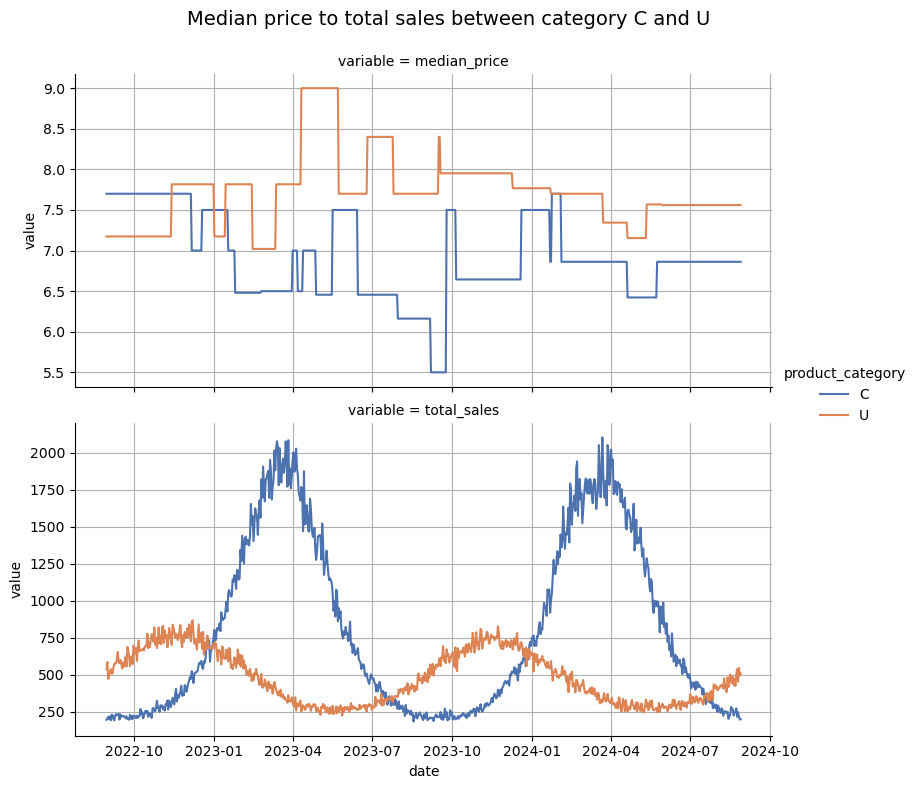

In [370]:

g= sns.relplot(
    data=df_catg_melted,
    x="date", y="value",
    hue="product_category",  row="variable",
    height=4, aspect=2, kind="line",
    palette='deep',
    facet_kws={'sharey': False, 'sharex': True},
)
for ax in g.axes.flat:
    ax.grid(True)  
    
g.fig.suptitle('Median price to total sales between category C and U', fontsize=14)
g.fig.subplots_adjust(top=0.9);


## Inspect median price to sales (demand) correlation
Theres a negative correlation between sales and price for both categories, inevitably from seasonality effect :
1. Category U has a stronger r^2 which was not indicative in price to sales trend. This needs to be inspected at product level. 

In [371]:
from scipy.stats.stats import pearsonr  

price_to_demand_cor=pd.DataFrame (index=['product_category'], columns=['r^2', 'p-value','decision'])
for prod_catg_ in df_category_trend.product_category.unique():
    #print (cat_)
    x=df_category_trend.loc[(df_category_trend.product_category==prod_catg_),'median_price'].to_numpy()
    y=df_category_trend.loc[(df_category_trend.product_category==prod_catg_),'total_sales'].to_numpy()
    pearsonr_ = pearsonr(x,y)
    r, p , dec_=pearsonr_[0], pearsonr_[1], "REJECT" if pearsonr_[1] < 0.05 else "ACCEPT"
    price_to_demand_cor.loc[prod_catg_,'r^2']=np.round(r,4)
    price_to_demand_cor.loc[prod_catg_,'p-value']=np.round(p,4)
    price_to_demand_cor.loc[prod_catg_,'decision']=dec_
    #print(f"The p-value is {chi_sq_result[1]:0.4f} and hence we {x} the null Hpothesis with {chi_sq_result[2]} degrees of freedom\n")

price_to_demand_cor

/var/folders/37/fvy907_51m358sjz5ntwm5_00000gn/T/ipykernel_50975/2885613035.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


,r^2,p-value,decision
product_category,NaN,NaN,NaN
C,-0.1464,0.0001,REJECT
U,-0.186,0.0,REJECT


# Inspect product level sales for category C 

1. products YoY shows changes.  
    1.1 porduct id 3,5,10 gained traction in 2024 .  
    1.2 product id 1,7,20  declined in 2024.  
    1.3. product id 4,6,8 stable YOY  
    
How can we bring back 1,7,20?  
Product 1,5,10 and 20 indicative price increased resulted in lower sales. However there are not many price data points to make a good estimate. Need to refine via season.

In [372]:
df_catg_c=_df.query('product_category=="C"').assign (
            month= lambda x:x.date.dt.month_name(),
            year=lambda x:x.date.dt.year
        ).copy()
df_catg_c_agg=df_catg_c.groupby (['product_id','year','month']).agg(

    num_days=('date','nunique'),
    price_med=('price','median'),
    total_sales=('sales_qty','sum')
)

df_catg_c_agg['total_sales'].groupby('product_id', group_keys=False)\
    .apply(lambda x: x.sort_values(ascending=False).head(5)) #get 5 top selling months


product_id  year  month   
1           2023  March       14157
                  April       12342
                  February     8779
                  May          5712
                  January      5573
10          2024  February     7670
                  March        5411
                  January      5159
                  April        4416
            2023  April        3403
19          2023  March        3241
            2024  March        3172
                  April        3051
            2023  April        2838
                  February     2636
20          2023  March        8410
                  April        7737
                  May          7135
                  February     6174
            2024  May          5278
3           2024  March        6619
                  April        4982
                  February     4701
            2023  January      3708
                  March        3414
4           2023  March        3873
                  February     3223
 

/var/folders/37/fvy907_51m358sjz5ntwm5_00000gn/T/ipykernel_50975/2523362083.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


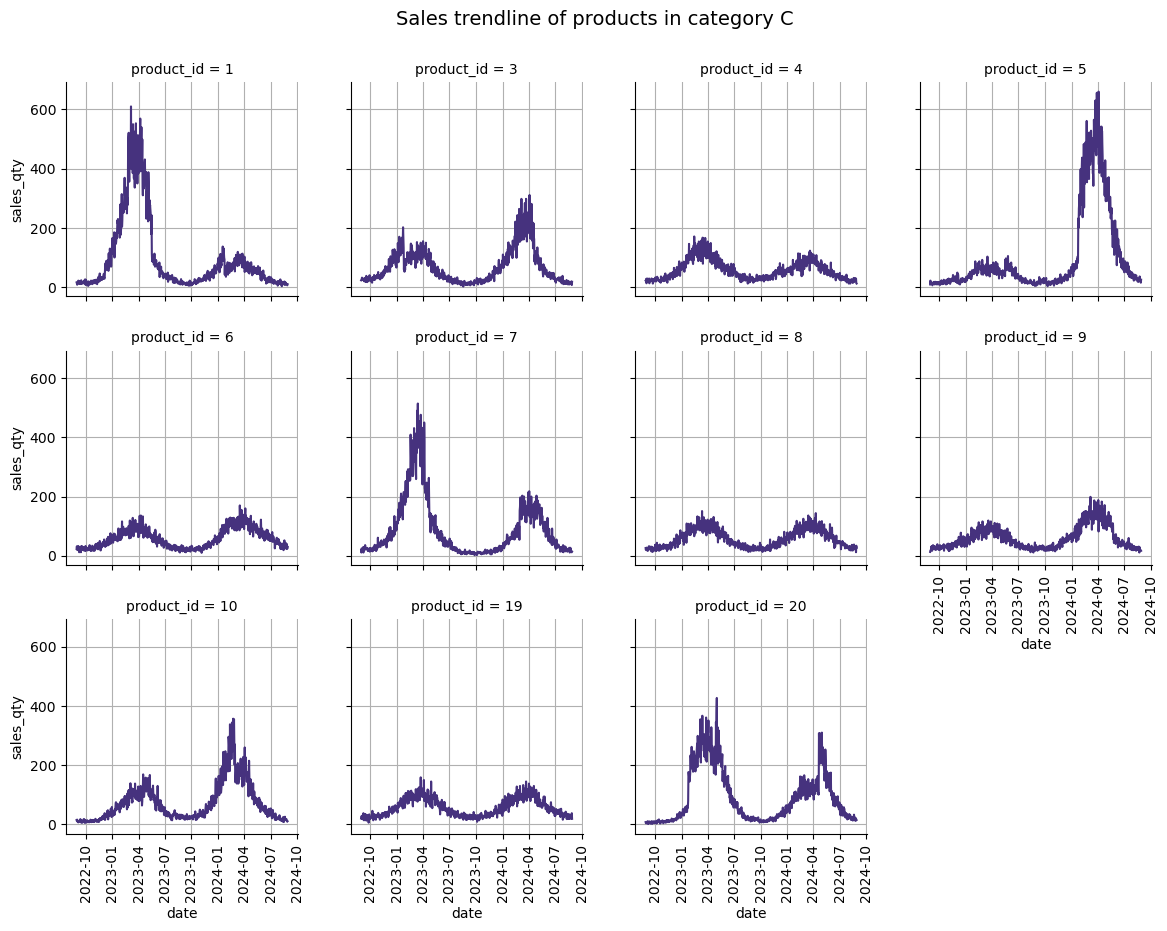

In [388]:
#visualize
g = sns.FacetGrid(df_catg_c, 
                col="product_id", 
                col_wrap=4, 
                sharex=True
                )
g.map_dataframe(sns.lineplot, x= 'date', y='sales_qty')


xformatter = mdates.DateFormatter("%m/%d/%y")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(xformatter)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  
    ax.grid(True)

g.fig.suptitle('Sales trendline of products in category C', fontsize=14)
g.fig.subplots_adjust(top=0.9);
plt.show()

# Regression plot for category C

Initial linear regression shows  (not many data points):
1. Product 1 ,5, 10,20 has a steep decline in sales quantity wrt to price.

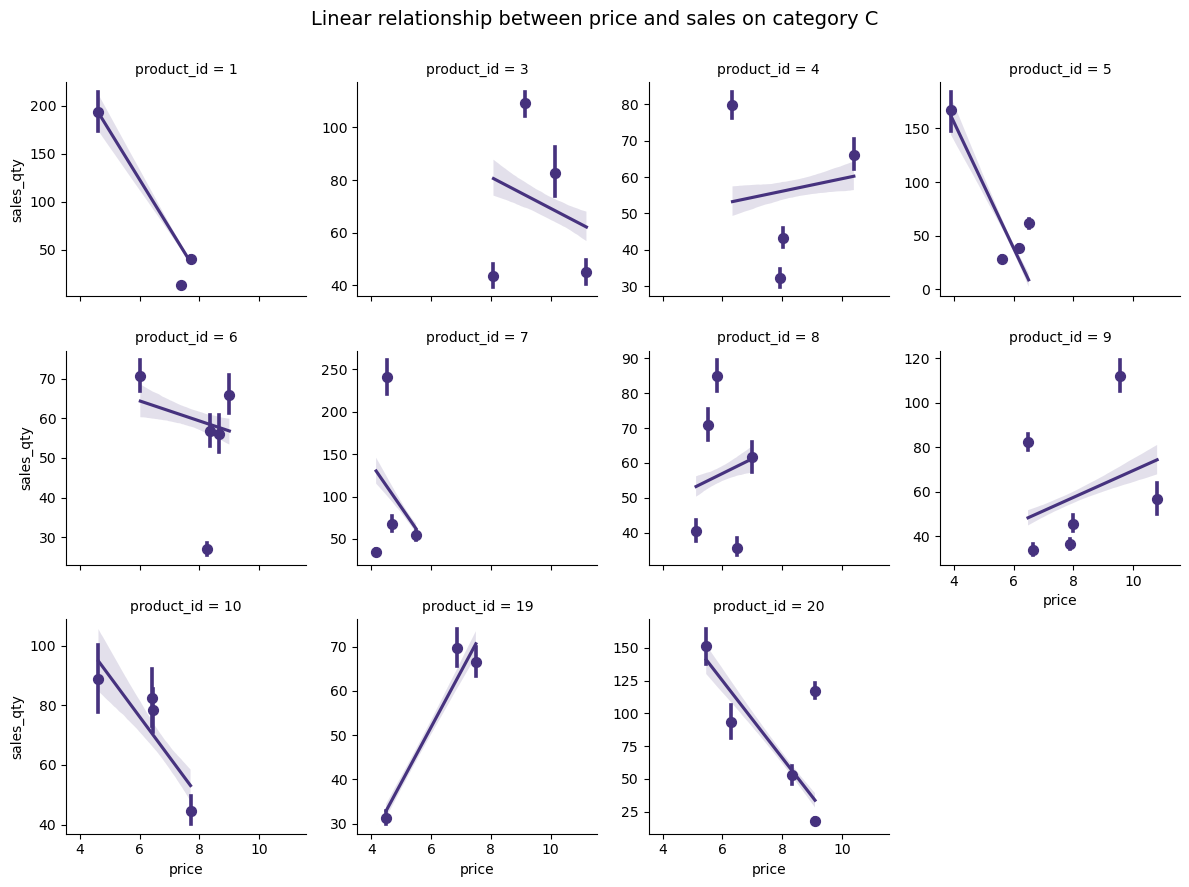

In [374]:
g = sns.FacetGrid(df_catg_c, col="product_id", col_wrap=4, sharey=False)
g.map(sns.regplot, "price", "sales_qty",  x_estimator=np.mean)
g.fig.suptitle('Linear relationship between price and sales on category C', fontsize=14)
g.fig.subplots_adjust(top=0.9);

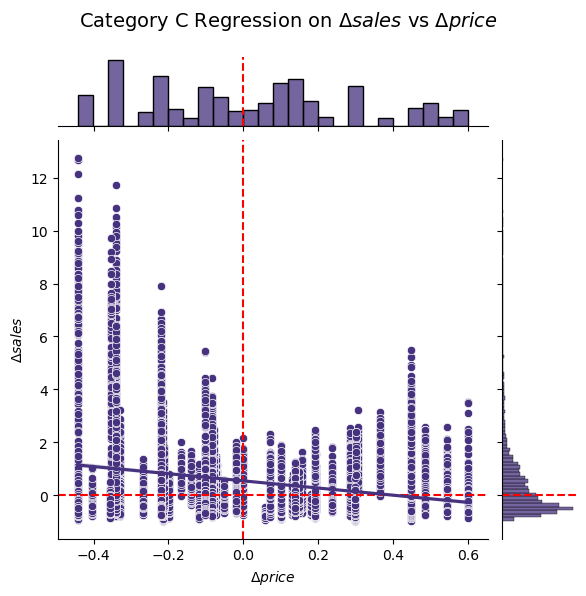

In [375]:

# delta_price and delta_sales are both normalized relative to their medians 
df_catg_c=df_catg_c.assign (
    delta_price= df_catg_c.groupby ('product_category')['price'].transform (lambda x:(x-x.median())/x.median()), 
    delta_sales= df_catg_c.groupby ('product_category')['sales_qty'].transform (lambda x:(x-x.median())/x.median()),
)
#visualize
g = sns.jointplot(data=df_catg_c, x="delta_price", y="delta_sales")
g.refline(
    x=df_catg_c["delta_price"].median(),
    y=df_catg_c["delta_sales"].median(), 
    color="red")

sns.regplot(data=df_catg_c, x="delta_price", y="delta_sales", scatter=False, ax=g.ax_joint)
g.ax_joint.set(
    xlabel=r"$\Delta price$",
    ylabel=r"$\Delta sales$"
)

g.fig.suptitle('Category C Regression on $\Delta sales$ vs $\Delta price$  ', fontsize=14)
g.fig.subplots_adjust(top=0.9);


## Regression Analysis
1. Using OLS may be simpler to translate to stake holders . However:  
The deltas graph does not indicate linearity, reason being its effected by seasonality, outliers, category specifics. Thus, this method should only be category specific.

2. OLS with transformation log(sales qty)- log(price)   
This would address most of the issues in point 1

3. A more rigorous regression, multi level regression given there are categories, seasonalities and product quality data.  
This would reduce the task of differentiating elasticity within the other variables, therefore provide better elasticity estimate and predictibility. 

In [376]:
# Ordinarly OLS with deltas
import statsmodels.api as sm

X= df_catg_c["delta_price"].values.reshape(-1, 1)
y= df_catg_c["delta_sales"].values.reshape(-1, 1)
X2 = sm.add_constant(X)
model = sm.OLS(y, X2)
result = model.fit()
print(result.summary())

print (f'\nCategory C elasticy: {result.params[1]:0.4f}, p-value= {result.pvalues[1]:0.4f}')  #elastic
print (f'A 1% increase in price result to  {result.params[1]:0.1f}% decline in sales')



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     442.1
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           1.36e-95
Time:                        10:14:27   Log-Likelihood:                -15262.
No. Observations:                8030   AIC:                         3.053e+04
Df Residuals:                    8028   BIC:                         3.054e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5425      0.018     30.000      0.0

In [387]:
#Ordinary OLS  log-log regression
log_X= np.log(df_catg_c["price"]).values.reshape(-1, 1)
log_y= np.log(df_catg_c["sales_qty"]).values.reshape(-1, 1)
log_X2 = sm.add_constant(log_X)
model = sm.OLS(log_y, log_X2)
result = model.fit()
print(result.summary())

print (f'\nCategory C elasticy: {result.params[1]:0.4f}, p-value= {result.pvalues[1]:0.4f}')  #elastic
print (f'A 1% increase in price result to  {result.params[1]:0.2f}% decline in sales')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     170.5
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           1.41e-38
Time:                        10:18:07   Log-Likelihood:                -10360.
No. Observations:                8030   AIC:                         2.072e+04
Df Residuals:                    8028   BIC:                         2.074e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7506      0.067     71.195      0.0

## Cross elasticity between products in category C

Cross Elasticity Demand 
A,B
​= % change in Quantity Demanded of A/% change in Price of B

If CED is positive: Product A and Product B are likely substitutes (e.g., coffee and tea).
If CED is negative: Product A and Product B are likely complements (e.g., printers and ink cartridges).
​	
 

In [429]:
product_list=df_catg_c.product_id.unique()
product_list

array(['1', '3', '4', '5', '6', '7', '8', '9', '10', '19', '20'],
      dtype=object)

In [448]:
# Simple example get product A delta price by cal_dt

# df_product_a=df_catg_c.query('product_id=="1"')[['date','delta_price']]
# df_product_b=df_catg_c.query('product_id=="3"')[['date','delta_sales']]

# df_merge_ab=df_product_a.merge(df_product_b, how='inner', left_on='date', right_on='date')

# y = df_merge_ab['delta_sales']
# X = df_merge_ab['delta_price']
# X = sm.add_constant(X)

# model = sm.OLS(y, X).fit()

# print(f'cross elasticty product id ==1 increase by 1% result in product id ==3: {model.params["delta_price"]}% sales')


cross elasticty product id 1 increase by 1% result in product id 3: -0.8537707834213198% sales


In [478]:
cross_elasticities = pd.DataFrame(columns=['Product_A', 'Product_B', 'Cross_Elasticity', 'p_value','r^2'])

#iteration
for product_a in product_list:
     df_product_a=df_catg_c.loc[(df_catg_c.product_id==product_a),['date', 'delta_price']]

     for product_b in product_list:
          if product_a != product_b:
    #         
               df_merge_ab = df_product_a.merge(df_catg_c.loc[(df_catg_c.product_id==product_b),['date', 'delta_sales']], how='inner',left_on='date', right_on='date')

               y = df_merge_ab['delta_sales']
               X = df_merge_ab['delta_price']
               X = sm.add_constant(X)
            
               #Simple linear regression.
               model = sm.OLS(y, X).fit()
               
               # Retrieve the cross-elasticity coefficient for product B with respect to product A
               cross_elasticity = model.params['delta_price']
               #print (model.params['delta_price'])
               #print (model.summary)
               #print (model.pvalues['delta_price'])
            
               # Append 
               cross_elasticities = cross_elasticities.append({
                    'Product_A': product_a,
                    'Product_B': product_b,
                    'Cross_Elasticity': cross_elasticity,
                    'p_value':model.pvalues['delta_price'],
                    'r^2':model.rsquared
               }, ignore_index=True)


/var/folders/37/fvy907_51m358sjz5ntwm5_00000gn/T/ipykernel_50975/3041548975.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cross_elasticities = cross_elasticities.append({
/var/folders/37/fvy907_51m358sjz5ntwm5_00000gn/T/ipykernel_50975/3041548975.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cross_elasticities = cross_elasticities.append({
/var/folders/37/fvy907_51m358sjz5ntwm5_00000gn/T/ipykernel_50975/3041548975.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cross_elasticities = cross_elasticities.append({
/var/folders/37/fvy907_51m358sjz5ntwm5_00000gn/T/ipykernel_50975/3041548975.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

Summary:
cross checking cross elasticity with visualization indicates
1. product 1 supplement from visualization seem to indicate 5,10,20 however from linear regression only Product 5 matters

In [482]:
#add suplement ind
cross_elasticities= cross_elasticities.assign(

    suplement_ind=np.where(cross_elasticities['Cross_Elasticity']>1,'Y','N')
)
cross_elasticities[np.abs(cross_elasticities.Cross_Elasticity)>1] # get siginificant change in elasticity only.

,Product_A,Product_B,Cross_Elasticity,p_value,r^2,suplement_ind
1,1,4,-1.384404,7.752689e-34,0.182981,N
2,1,5,4.492488,5.129836e-19,0.103368,Y
4,1,7,-3.762955,7.591323e-28,0.151640,N
9,1,20,-2.416387,4.966305e-14,0.075033,N
10,3,1,-3.806461,1.841347e-09,0.048456,N
12,3,5,4.734129,1.371734e-11,0.060897,Y
14,3,7,-2.445303,5.319218e-07,0.033972,N
17,3,10,1.496857,4.862814e-06,0.028307,Y
19,3,20,1.903580,1.991060e-05,0.024704,Y
20,4,1,4.465051,7.328632e-25,0.135600,Y


# Multilevel regression (Mixed LM)

Consider all skus

In [403]:
# multilevel regression
#failure to converge could possibly be due to seasonality.

from statsmodels.regression.mixed_linear_model import MixedLM

_df['log_price'] = np.log(_df['price'])
_df['log_sales'] = np.log(_df['sales_qty'])

# Fit a mixed-effects model with a random intercept for 'product_category'
model = MixedLM(_df['log_sales'], sm.add_constant(_df['log_price']), groups=_df['product_category'])
result = model.fit()

print(result.summary())

# Random effects represent category-specific variations
print(result.random_effects) #Result indicates symmetry: The two categories nulify each other, where C is underperforming and U is overperforming.
# Additional context:
#Group C: indicates that the intercept for group C is 0.014904 units lower than the overall intercept. Sales are expected to be slightly lower than what the fixed effects predict.
#Group U: indicates that the intercept for group U is 0.014904 units higher than the overall intercept. Sales are expected to be slightly higher than the fixed effects predict.

# Fixed effect (overall price elasticity)
overall_elasticity = result.fe_params['log_price']
print(f'Overall Price Elasticity: {overall_elasticity}')

/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_sales  
No. Observations: 14600   Method:             REML       
No. Groups:       2       Scale:              0.5155     
Min. group size:  6570    Log-Likelihood:     -15887.4351
Max. group size:  8030    Converged:          No         
Mean group size:  7300.0                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
const          4.355    0.056  77.785 0.000  4.245  4.465
log_price     -0.235    0.022 -10.856 0.000 -0.278 -0.193
Group Var      0.003                                     

{'C': Group Var   -0.014904
dtype: float64, 'U': Group Var    0.014904
dtype: float64}
Overall Price Elasticity: -0.2350810745153778


/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 11.358049
  warnings.warn(msg, ConvergenceWarning)
/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear

In [379]:
# allowing variation of intercept and slope by product categories
model = MixedLM(_df['log_sales'], sm.add_constant(_df['log_price']), 
                groups=_df['product_category'], exog_re=_df[['log_price']])

result = model.fit()

print(result.summary())

# Random effects represent category-specific variations
print(result.random_effects)

# Fixed effect (overall price elasticity)
overall_elasticity = result.fe_params['log_price']
print(f'Overall Price Elasticity: {overall_elasticity}')

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_sales  
No. Observations: 14600   Method:             REML       
No. Groups:       2       Scale:              0.5151     
Min. group size:  6570    Log-Likelihood:     -15882.6908
Max. group size:  8030    Converged:          Yes        
Mean group size:  7300.0                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
const          4.365    0.043 101.600 0.000  4.281  4.449
log_price     -0.240    0.042  -5.776 0.000 -0.322 -0.159
log_price Var  0.003                                     

{'C': log_price   -0.012494
dtype: float64, 'U': log_price    0.012494
dtype: float64}
Overall Price Elasticity: -0.24018144452701612


/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


### Incorporating Product Quality and Seasonality 


In [380]:
#prepare data with seasonality indicator
_df2=pd.get_dummies(_df.assign (month=_df.date.dt.month_name()), columns=['month'], drop_first=True)
_df2.head()

,product_id,product_category,product_quality,date,price,sales_qty,log_price,log_sales,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,1,C,20,2022-08-30,7.7,16,2.04122,2.772589,1,0,0,0,0,0,0,0,0,0,0
1,1,C,20,2022-08-31,7.7,13,2.04122,2.564949,1,0,0,0,0,0,0,0,0,0,0
2,1,C,20,2022-09-01,7.7,8,2.04122,2.079442,0,0,0,0,0,0,0,0,0,0,1
3,1,C,20,2022-09-02,7.7,14,2.04122,2.639057,0,0,0,0,0,0,0,0,0,0,1
4,1,C,20,2022-09-03,7.7,17,2.04122,2.833213,0,0,0,0,0,0,0,0,0,0,1


In [389]:
# incorporating product quality and seasonality into mixed model

_df2['log_price'] = np.log(_df2['price'])
_df2['log_sales'] = np.log(_df2['sales_qty'])

# Define the regressors: log_price and product_quality
# Upon advisement form Edward improve model by adding an interaction term month*log_price (as price and month may be highly correlated)
X = _df2[['log_price', 'product_quality'] + [col for col in _df2 if 'month_' in col]]
X = sm.add_constant(X)  # Add intercept

# Fit a mixed-effects model with a random intercept for other regressor
model = MixedLM(_df2['log_sales'], X, groups=_df2['product_category'],exog_re=_df[['log_price']]) # exog_re=_df[['log_price', 'product_quality']] allowing variability in intercept on
result = model.fit()

# Print the summary of the model
print(result.summary())
#the product quality does not effect sales
# the Scale (Error Variance) reduced.
# the log-likelihood is an improvement from previous MLM models but its still very far from 0.
# seasonality varies across the two groups. I'm not sure how to differentiate seasonality in the model.



/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: log_sales  
No. Observations:   14600   Method:             REML       
No. Groups:         2       Scale:              0.3895     
Min. group size:    6570    Log-Likelihood:     -13876.7274
Max. group size:    8030    Converged:          Yes        
Mean group size:    7300.0                                 
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
const            4.651    0.042 111.408 0.000  4.569  4.733
log_price       -0.238    0.036  -6.543 0.000 -0.309 -0.167
product_quality  0.000    0.000   2.303 0.021  0.000  0.001
month_August    -0.824    0.025 -32.479 0.000 -0.874 -0.774
month_December  -0.153    0.025  -6.058 0.000 -0.203 -0.104
month_February   0.188    0.026   7.279 0.000  0.137  0.239
month_January    0.058    0.025   2.307 0.021  0.00

/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [382]:
print(result.random_effects)
overall_elasticity = result.fe_params['log_price']
quality_effect = result.fe_params['product_quality']
print(f'Overall Price Elasticity: {overall_elasticity}')
print(f'Effect of Product Quality: {quality_effect}')

{'C': log_price   -0.011067
dtype: float64, 'U': log_price    0.011067
dtype: float64}
Overall Price Elasticity: -0.23813436501333332
Effect of Product Quality: 0.00046978826761654303


# Random Forest
Using random forest to predict sale and then model elasticity base on percent increase in price to account for non linear price-volume behaviour

In [483]:
# using random forrest to make prediction on sales

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score



In [486]:
# Features and target
X = _df2[['price', 'month_August', 'month_December', 'month_February', 'month_January', 'month_July', 'month_June', 'month_March', 'month_May', 'month_November', 'month_October', 'month_September']]
y = _df2['sales_qty']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [488]:
# Initialize and train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 415.26928329940756
R^2 Score: 0.8920750357320548


In [494]:
# Define percentage change in price (e.g., 5% increase)
percentage_increase = 0.05

# Baseline: Predict units sold with current prices
baseline_units = rf.predict(X)

# Scenario: Predict units sold with a percentage price increase
X_price_increase = X.copy()
X_price_increase['price'] = X_price_increase['price'] * (1 + percentage_increase)

new_units = rf.predict(X_price_increase)

# Elasticity calculation
price_change_pct = percentage_increase  # Same for all items in this example
quantity_change_pct = (new_units - baseline_units) / baseline_units
elasticity = quantity_change_pct / price_change_pct


print (f' new units with 5% increase in price ${new_units.sum(): 0.2f}, vs baseline_unit ${baseline_units.sum():0.2f}')

 new units with 5% increase in price $ 874053.76, vs baseline_unit $941821.63


### Supplmentary

Inspect products in Category U

In [392]:
df_catg_u=_df.query('product_category=="U"').assign (
            month= lambda x:x.date.dt.month_name(),
            year=lambda x:x.date.dt.year
        ).copy()
df_catg_u_agg=df_catg_u.groupby (['product_id','year','month']).agg(

    num_days=('date','nunique'),
    price_med=('price','median'),
    total_sales=('sales_qty','sum')
)

df_catg_u_agg.groupby('product_id', group_keys=False)\
    .apply(lambda x: x.sort_values(by='total_sales',ascending=False).head(5)) #get 5 top selling months


num_days  price_med  total_sales
product_id year month                                     
11         2023 December        31   8.051276         2353
                November        30   8.051276         2333
           2022 November        30   7.020000         2184
           2023 January         31   7.020000         2149
                October         31   8.051276         2073
12         2022 November        30   9.000000         3260
                October         31   9.000000         3215
                December        31   9.000000         3134
           2023 November        30   7.951385         2862
                December        31   7.951385         2679
13         2022 November        30  11.200000         2545
           2023 November        30  11.200000         2502
           2022 December        31  11.200000         2391
           2023 December        31  11.200000         2379
                October         31  11.200000         2335
14         2022 November        30   6.469402         2460
                October         31   6.469402         2431
           2023 November        30   5.582523         2414
           2022 December        31   6.469402         2369
           2023 October         31   4.200000         2319
15         2023 November        30   5.040000         2522
           2022 November        30   7.816368         2446
                December        31   7.816368         2443
           2023 December        31   5.040000         2419
           2022 October         31   6.908142         2339
16         2022 November        30   8.400000         2596
           2023 November        30   8.400000         2563
           2022 December        31   8.400000         2440
           2023 October         31   8.400000         2408
                December        31   7.767960         2346
17         2022 December        31   7.173730         2623
                October         31   7.173730         2440
                November        30   7.173730         2405
           2023 November        30   6.151663         2368
                December        31   6.151663         2366
18         2022 November        30   5.442420         2517
                October         31   5.442420         2449
           2023 November        30   7.700000         2406
                December        31   7.700000         2378
                October         31   7.700000         2294
2          2022 December        31  11.050955         3107
           2023 January         31  11.050955         2770
           2022 November        30  11.050955         2479
                October         31  11.050955         2323
           2023 October         31  11.922810         2242

/var/folders/37/fvy907_51m358sjz5ntwm5_00000gn/T/ipykernel_50975/3428877525.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


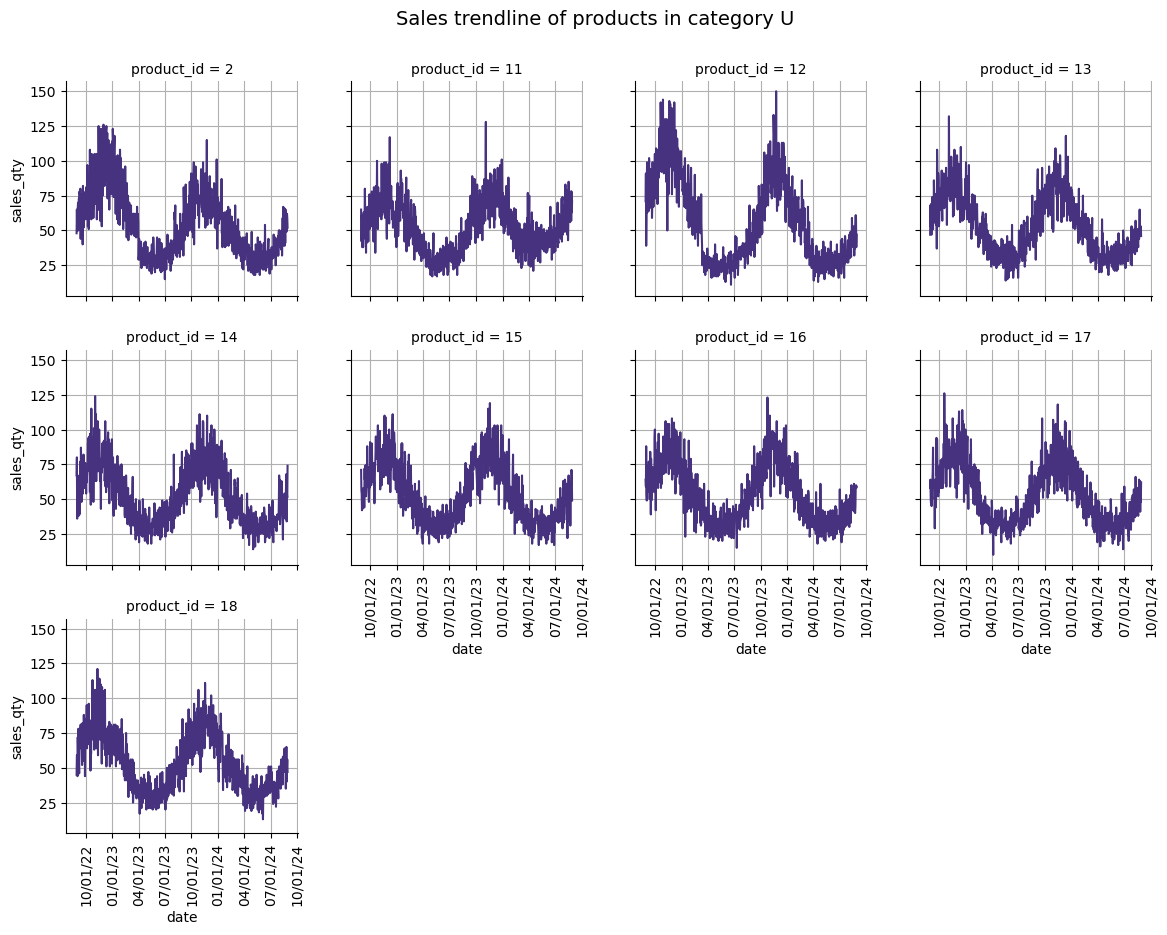

In [384]:
g = sns.FacetGrid(df_catg_u, 
                col="product_id", 
                col_wrap=4, 
                sharex=True
                )
g.map_dataframe(sns.lineplot, x= 'date', y='sales_qty')

xformatter = mdates.DateFormatter("%m/%d/%y")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(xformatter)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  
    ax.grid(True)
g.axes[0].xaxis.set_major_formatter(xformatter)
g.fig.suptitle('Sales trendline of products in category U', fontsize=14)
g.fig.subplots_adjust(top=0.9);
plt.show()

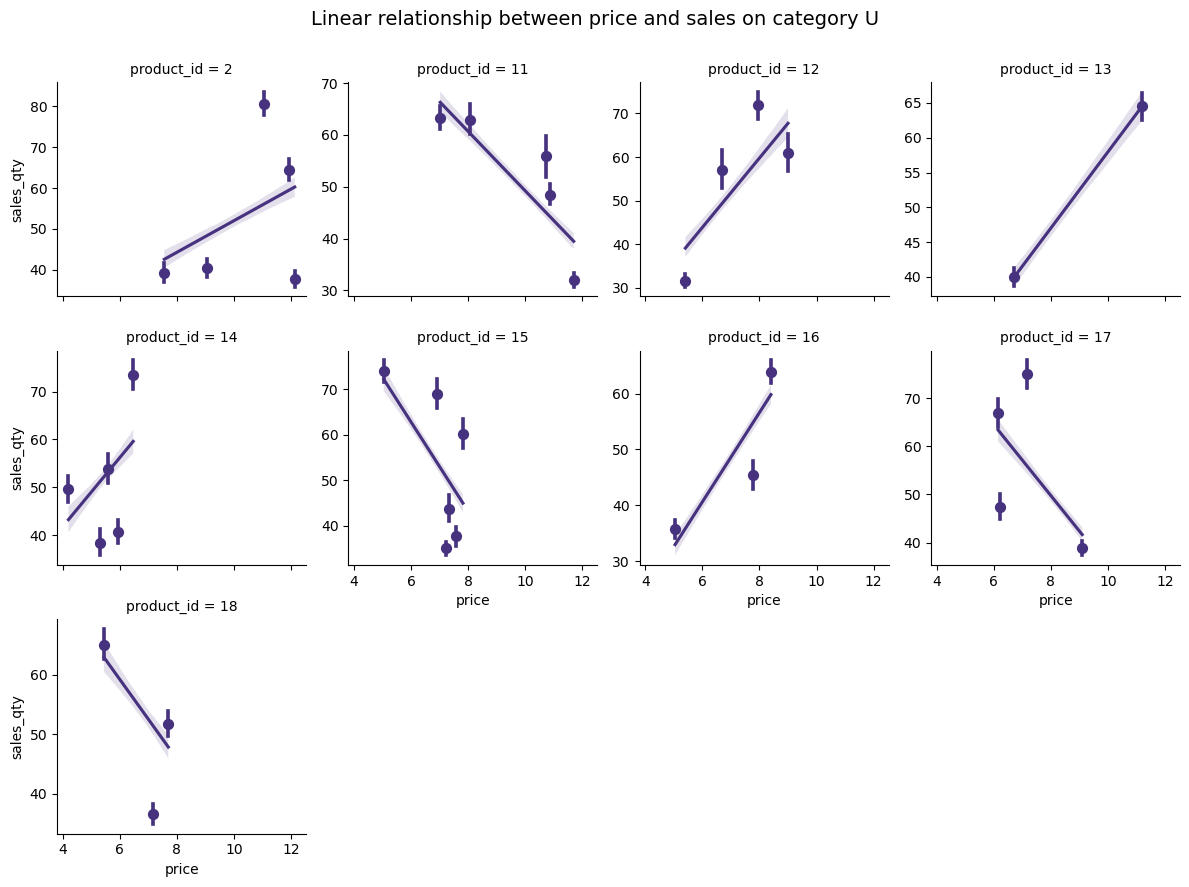

In [385]:
g = sns.FacetGrid(df_catg_u, col="product_id", col_wrap=4, sharey=False)
g.map(sns.regplot, "price", "sales_qty",  x_estimator=np.mean)
g.fig.suptitle('Linear relationship between price and sales on category U', fontsize=14)
g.fig.subplots_adjust(top=0.9);

# product 13 has only two data points. we should drop product 13 from data.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     17.57
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           2.81e-05
Time:                        10:14:35   Log-Likelihood:                -4119.9
No. Observations:                6570   AIC:                             8244.
Df Residuals:                    6568   BIC:                             8257.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0708      0.006     12.589      0.0

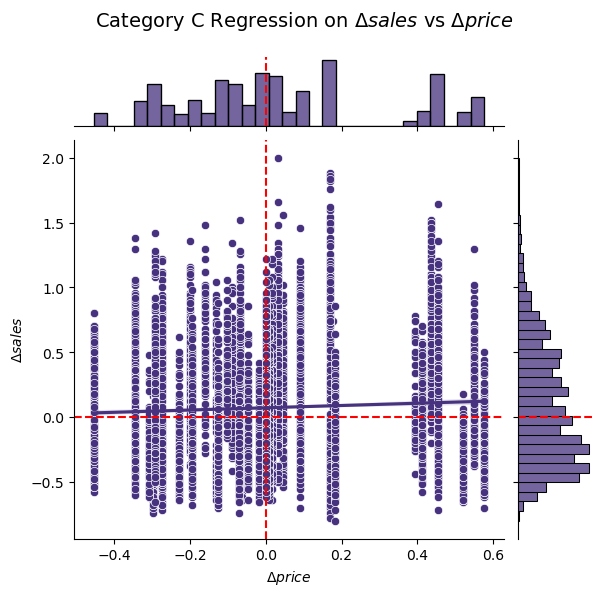

In [386]:

# delta_price and delta_sales are both normalized relative to their medians 
df_catg_u=df_catg_u.assign (
    delta_price=   df_catg_u.groupby ('product_category')['price'].transform (lambda x:(x-x.median())/x.median()), 
    delta_sales=   df_catg_u.groupby ('product_category')['sales_qty'].transform (lambda x:(x-x.median())/x.median()),
)
#visualize
g = sns.jointplot(data=df_catg_u, x="delta_price", y="delta_sales")
g.refline(
    x=df_catg_u["delta_price"].median(),
    y=df_catg_u["delta_sales"].median(), 
    color="red")
sns.regplot(data=df_catg_u, x="delta_price", y="delta_sales", scatter=False, ax=g.ax_joint)
g.ax_joint.set(
    xlabel=r"$\Delta price$",
    ylabel=r"$\Delta sales$"
)
g.fig.suptitle('Category C Regression on $\Delta sales$ vs $\Delta price$  ', fontsize=14)
g.fig.subplots_adjust(top=0.9);

;

X= df_catg_u["delta_price"].values.reshape(-1, 1)
y= df_catg_u["delta_sales"].values.reshape(-1, 1)
X2 = sm.add_constant(X)
model = sm.OLS(y, X2)
result = model.fit()
print(result.summary())

print (f'Category C elasticy: {result.params[1]:0.4f}, p-value= {result.pvalues[1]:0.4f}') 
#inelastic. It is unusual as earlier we saw a strong negative R^2 in category U. This maybe due to a bimodal delta price distribution.
#warrant for product level inspection. 



## General Plan
1. Forecast next season revenue, increase by x% base on clients goals from the three different models and to apply feed back loop. The best MSE / F1 Score from the three models will be choosen to recommend the elasticity.
2. Given elasticities, we then optimize price points to reach new sales objectives:  
    2.1. Simplistic categorical regression level for elasticity estimate.  
    2.2. Rigorous Multi level regression for elasticity estimates
    2.3  Complex product level elasticity:  
        2.2.1 cross price elasticity estimate. Find complementary (negative E) /subsitutes (positive E) products.  
        The idea is to iterate over each product delta sales_A/delta price_B for their elasticity dependencies. 

### Revenue function (objective function)
revenue = sales * price

    objective_function( price , curr_price, sales, elasticity):

    $$new revenue=  (1 + elasticity * delta_price) * price $$

    return -new revenue

    where 
    $$new_sales=(1 + elasticity * delta_price)$$
    $$delta_price = (price -curr_price )/curr_price$$ 

Delta price can be defined as average chage of price at category level.
or else product level, then we would require target sales for product level. 



